# Section 1: Importing the Data & Data Preprocessing

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torchvision
from torchvision import datasets, transforms
from collections import Counter
from torch.autograd import Variable
import time
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

## Data loading and inspection

### B2.1a

In [2]:
#setting the seed for reproducibility
torch.manual_seed(1746174)

In [3]:
transform = transforms.Compose([transforms.ToTensor()])

#import the training data
train_dataset = datasets.FashionMNIST(root='./data', train=True,
                                        download=True, transform=transform)

#import the test data
test_dataset = datasets.FashionMNIST(root='./data', train=False,
                                       download=True, transform=transform)

print('Training set size:', len(train_dataset))
print('Test set size:',len(test_dataset))

Training set size: 60000
Test set size: 10000


FashionMNIST dataset has 60000 images for training and 10000 images for testing. We can see the category of the items (along with label) from the store as shown below, there are 10 classes in total.

In [4]:
train_dataset.class_to_idx

{'T-shirt/top': 0,
 'Trouser': 1,
 'Pullover': 2,
 'Dress': 3,
 'Coat': 4,
 'Sandal': 5,
 'Shirt': 6,
 'Sneaker': 7,
 'Bag': 8,
 'Ankle boot': 9}

<BarContainer object of 10 artists>

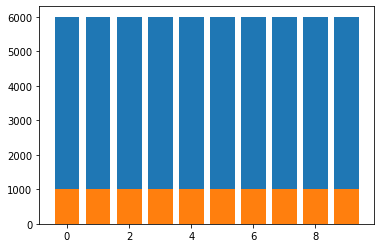

In [5]:
#distribution of the train and test data across the class
tr_d = train_dataset.targets.numpy()
dist_tr = Counter(tr_d)
plt.bar(dist_tr.keys(), dist_tr.values())

ts_d = test_dataset.targets.numpy()
dist_ts = Counter(ts_d)
plt.bar(dist_ts.keys(), dist_ts.values())

In [6]:
#check for any Null values
print("Train_data:", sum(np.isnan(tr_d)))
print("Test_data:", sum(np.isnan(ts_d)))

Train_data: 0
Test_data: 0


Above plot shows that both train and test dataset is divided equally among the 10 classes and there are no missing values.

In [7]:
#intialise the parameters
batch_size = 8
epochs = 4
input_dim = 784
output_dim = 10
lr_rate = 0.001

In [8]:
#load the training data
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

#load the test data
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

### B2.1b

We can visualise the sample images of each class from the train dataset as below.

T-shirt/top


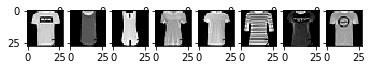

Trouser


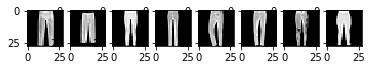

Pullover


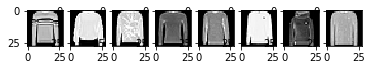

Dress


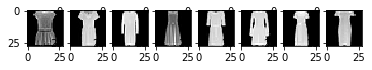

Coat


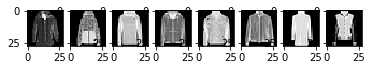

Sandal


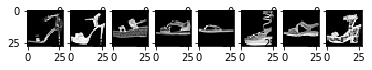

Shirt


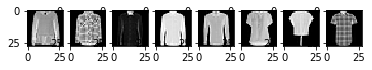

Sneaker


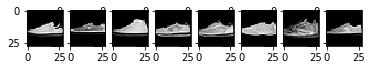

Bag


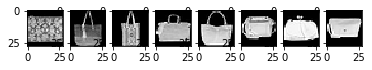

Ankle boot


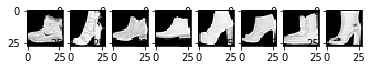

In [9]:
for i in range(0, 10):
    # show images
    for j in range(0,8):
        plt.subplot(1, 8, j+1)
        #plt.title(train_dataset.classes[i])
        plt.imshow(train_dataset.data[train_dataset.targets==i][j], cmap=plt.get_cmap('gray'))
    # print labels
    print(train_dataset.classes[i])
    plt.show()

# Section 2:  Supervised learning on Fashion-MNIST

## B2.3 Logistic regression

### B2.3a

### Using Sklearn to build LGR model

In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.metrics import plot_confusion_matrix

In [11]:
#LR model with saga solver and 100 iterations
LRClassifier = LogisticRegression(penalty='none', random_state=1746174, solver='saga', max_iter=100, n_jobs=-1)

In [12]:
X_train = train_dataset.data.numpy()
Y_train = train_dataset.targets.numpy()
X_test = test_dataset.data.numpy()
Y_test = test_dataset.targets.numpy()

In [13]:
#flatten the images
nsamples, nx, ny = X_train.shape
X_train = X_train.reshape((nsamples,nx*ny))

nsamples, nx, ny = X_test.shape
X_test = X_test.reshape((nsamples,nx*ny))

In [14]:
t0 = time.time()
LRClassifier.fit(X_train, Y_train)
t1 = time.time()

C:\Users\varma\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


The model didn't converge with 100 iteration, we may increase the max_iteartions to avoid the warning but for the time constraint will go with 100 iterations. 

In [15]:
#M1 - Training accuracy
tr_score_lr = LRClassifier.score(X_train, Y_train)
print(tr_score_lr)

0.87615


In [16]:
#M2 - Testing accuracy
te_score_lr = LRClassifier.score(X_test, Y_test)
print(te_score_lr)

0.8413


In [17]:
#M3 - Training Time in secs
tt_lr = round(t1-t0, 3)
tt_lr

200.835

In case of Logistic Regression, learnable parameters are the weights/coefficients of the input features and the bias term

In [18]:
#M4 - Learnable parameters
total_lor_params = LRClassifier.coef_.size + LRClassifier.intercept_.size
print("Learnable Parameters of the model:", total_lor_params)

Learnable Parameters of the model: 7850


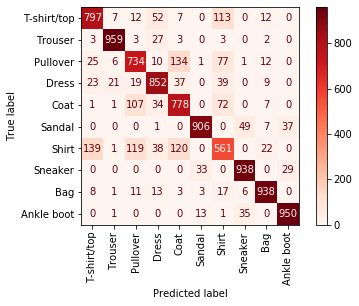

In [19]:
#Confusion Matrix
plot_confusion_matrix(LRClassifier, X_test, Y_test,
                               display_labels=test_dataset.classes,
                               cmap=plt.cm.Reds, values_format='d', xticks_rotation='vertical')
plt.show()

In [20]:
print(classification_report(Y_test,LRClassifier.predict(X_test)))

              precision    recall  f1-score   support

           0       0.80      0.80      0.80      1000
           1       0.96      0.96      0.96      1000
           2       0.73      0.73      0.73      1000
           3       0.83      0.85      0.84      1000
           4       0.72      0.78      0.75      1000
           5       0.95      0.91      0.93      1000
           6       0.64      0.56      0.60      1000
           7       0.91      0.94      0.92      1000
           8       0.93      0.94      0.93      1000
           9       0.94      0.95      0.94      1000

    accuracy                           0.84     10000
   macro avg       0.84      0.84      0.84     10000
weighted avg       0.84      0.84      0.84     10000



### B2.3b

In [21]:
#LR with L1 Regularisation penality, saga solver and 100 iterations
LRClassifier_L1 = LogisticRegression(penalty='l1', random_state=1746174, solver='saga', max_iter=100, n_jobs=-1)

In [22]:
t0 = time.time()
LRClassifier_L1.fit(X_train, Y_train)
t1 = time.time()

C:\Users\varma\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


In [23]:
#M1 - Training accuracy
tr_score_lr_l1 = LRClassifier_L1.score(X_train, Y_train)
print(tr_score_lr_l1)

0.8761


In [24]:
#M2 - Testing accuracy
te_score_lr_l1 = LRClassifier_L1.score(X_test, Y_test)
print(te_score_lr_l1)

0.8413


In [25]:
#M3 - Training Time in secs
tt_lr_l1 = round(t1-t0, 3)
tt_lr_l1

648.861

In [26]:
#M4 - Learnable parameters
total_lor_l1_params = LRClassifier_L1.coef_.size + LRClassifier_L1.intercept_.size
print("Learnable Parameters of the model:", total_lor_l1_params)

Learnable Parameters of the model: 7850


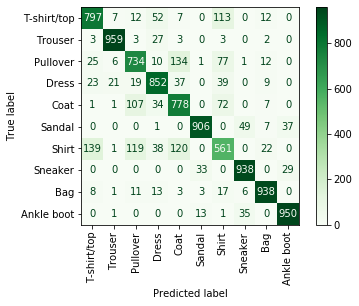

In [27]:
#Confusion Matrix
plot_confusion_matrix(LRClassifier_L1, X_test, Y_test,
                               display_labels=test_dataset.classes,
                               cmap=plt.cm.Greens, values_format='d', xticks_rotation='vertical')
plt.show()

In [28]:
print(classification_report(Y_test,LRClassifier_L1.predict(X_test)))

              precision    recall  f1-score   support

           0       0.80      0.80      0.80      1000
           1       0.96      0.96      0.96      1000
           2       0.73      0.73      0.73      1000
           3       0.83      0.85      0.84      1000
           4       0.72      0.78      0.75      1000
           5       0.95      0.91      0.93      1000
           6       0.64      0.56      0.60      1000
           7       0.91      0.94      0.92      1000
           8       0.93      0.94      0.93      1000
           9       0.94      0.95      0.94      1000

    accuracy                           0.84     10000
   macro avg       0.84      0.84      0.84     10000
weighted avg       0.84      0.84      0.84     10000



### B2.3c

In [29]:
#LR with L2 Regularisation penality, saga solver and 100 iterations
LRClassifier_L2 = LogisticRegression(penalty='l2', random_state=1746174, solver='saga', max_iter=100)

In [30]:
t0 = time.time()
LRClassifier_L2.fit(X_train, Y_train)
t1 = time.time()

C:\Users\varma\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


In [31]:
#M1 - Training accuracy
tr_score_lr_l2 = LRClassifier_L2.score(X_train, Y_train)
print(tr_score_lr_l2)

0.87615


In [32]:
#M2 - Testing accuracy
te_score_lr_l2 = LRClassifier_L2.score(X_test, Y_test)
print(te_score_lr_l2)

0.8413


In [33]:
#M3 - Training Time in secs
tt_lr_l2 = round(t1-t0, 3)
tt_lr_l2

200.052

In [34]:
#M4 - Learnable parameters
total_lor_l2_params = LRClassifier_L2.coef_.size + LRClassifier_L2.intercept_.size
print("Learnable Parameters of the model:", total_lor_l2_params)

Learnable Parameters of the model: 7850


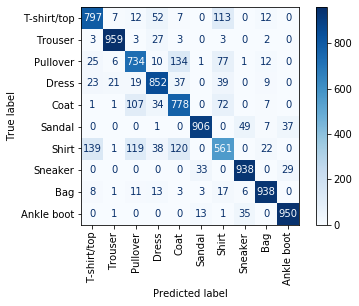

In [35]:
#Confusion Matrix
plot_confusion_matrix(LRClassifier_L2, X_test, Y_test,
                               display_labels=test_dataset.classes,
                               cmap=plt.cm.Blues, values_format='d', xticks_rotation='vertical')
plt.show()

In [36]:
print(classification_report(Y_test,LRClassifier_L2.predict(X_test)))

              precision    recall  f1-score   support

           0       0.80      0.80      0.80      1000
           1       0.96      0.96      0.96      1000
           2       0.73      0.73      0.73      1000
           3       0.83      0.85      0.84      1000
           4       0.72      0.78      0.75      1000
           5       0.95      0.91      0.93      1000
           6       0.64      0.56      0.60      1000
           7       0.91      0.94      0.92      1000
           8       0.93      0.94      0.93      1000
           9       0.94      0.95      0.94      1000

    accuracy                           0.84     10000
   macro avg       0.84      0.84      0.84     10000
weighted avg       0.84      0.84      0.84     10000



## B2.4 Convolutional Neural networks 

### B2.4a

In [37]:
#CNN with two Conv layers and two FC layers and with randomly chosen output channels at each layer.  
class CNNet1(nn.Module):
    def __init__(self):
        super(CNNet1, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

CNN_Classifier = CNNet1()

The kernel sizes are chosen accordingly using the convolution width & height output formulae as mentioned in the pytorch Conv2d API to get the desired output dimensions.

In [38]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(CNN_Classifier.parameters(), lr=0.001, momentum=0.9)
max_epochs=4

In [39]:
t0 = time.time()
for epoch in range(max_epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = CNN_Classifier(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 1500 == 1499:    # print every 1500 mini-batches
            print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 1500))
            running_loss = 0.0

t1 = time.time()
print('Finished Training!')

[1,  1500] loss: 1.369
[1,  3000] loss: 0.745
[1,  4500] loss: 0.633
[1,  6000] loss: 0.576
[1,  7500] loss: 0.529
[2,  1500] loss: 0.502
[2,  3000] loss: 0.484
[2,  4500] loss: 0.455
[2,  6000] loss: 0.453
[2,  7500] loss: 0.429
[3,  1500] loss: 0.413
[3,  3000] loss: 0.394
[3,  4500] loss: 0.388
[3,  6000] loss: 0.386
[3,  7500] loss: 0.381
[4,  1500] loss: 0.349
[4,  3000] loss: 0.364
[4,  4500] loss: 0.355
[4,  6000] loss: 0.365
[4,  7500] loss: 0.345
Finished Training!


In [40]:
#M1 - Training Accuracy (Accuracy for train data)
correct = 0
total = 0
for images, labels in trainloader:
    outputs = CNN_Classifier(images)
    _, predicted = torch.max(outputs.data, 1)
    total+= labels.size(0)
    correct+= (predicted == labels).sum().item()
    
tr_accuracy_cnn1 = 100 * correct/total
print('Accuracy of the network on the 60000 train images: ', tr_accuracy_cnn1)

Accuracy of the network on the 60000 train images:  88.41


In [41]:
#M2 - Testing Accuracy (Accuracy for test data)
correct = 0
total = 0
Y_test_label = []
predictions = []
for images, labels in testloader:
    outputs = CNN_Classifier(images)
    _, predicted = torch.max(outputs.data, 1)
    total+= labels.size(0)
    correct+= (predicted == labels).sum().item()
    Y_test_label.extend(labels.tolist())
    predictions.extend(predicted.tolist())
    
te_accuracy_cnn1 = 100 * correct/total
print('Accuracy of the network on the 10000 test images: ', te_accuracy_cnn1)

Accuracy of the network on the 10000 test images:  87.36


In [42]:
#M3 - Training Time in secs
tt_cnn1 = round(t1-t0, 3)
tt_cnn1

114.056

Learnable parameters at each convolution layer are calculated using the formula of 
((shape of width of the filter * shape of height of the filter * number of filters in the previous layer+1)*number of filters)
and for the FC layer, ((previous layer neurons p + 1) * current layer neurons c).

In [43]:
#M4 - Learnable Parameters
conV1 = (5*5*1 + 1)*6    #5x5 kernel, 6 output feature maps, 1 input channel
conV2 = (5*5*6 + 1)*16    #5x5 kernel, 16 output feature maps, 6 input channel
fc1 = (16*4*4 + 1)*120    #16x4x4 input, 120 output units
fc2 = (120 + 1)*10        #120 input, 10 output
total_cnn1_params = conV1 + conV2 + fc1 + fc2
print("Learnable Parameters of the model:", total_cnn1_params)

Learnable Parameters of the model: 34622


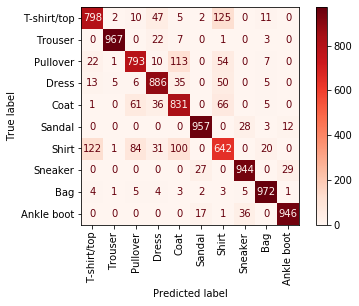

In [44]:
#Confusion Matrix
cm = confusion_matrix(Y_test_label, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_dataset.classes)
disp.plot(cmap='Reds', xticks_rotation='vertical', values_format='d')

In [45]:
print(classification_report(Y_test_label,predictions))

              precision    recall  f1-score   support

           0       0.83      0.80      0.81      1000
           1       0.99      0.97      0.98      1000
           2       0.83      0.79      0.81      1000
           3       0.86      0.89      0.87      1000
           4       0.76      0.83      0.79      1000
           5       0.95      0.96      0.95      1000
           6       0.68      0.64      0.66      1000
           7       0.93      0.94      0.94      1000
           8       0.95      0.97      0.96      1000
           9       0.96      0.95      0.95      1000

    accuracy                           0.87     10000
   macro avg       0.87      0.87      0.87     10000
weighted avg       0.87      0.87      0.87     10000



### B2.4b

In [46]:
#CNN with two Conv layers and five FC layers.
class CNNet2(nn.Module):
    def __init__(self):
        super(CNNet2, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 56)
        self.fc4 = nn.Linear(56, 28)
        self.fc5 = nn.Linear(28, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = self.fc5(x)
        return x

CNN_Classifier = CNNet2()

In [47]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(CNN_Classifier.parameters(), lr=0.001, momentum=0.9)
max_epochs=4

In [48]:
t0 = time.time()
for epoch in range(max_epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = CNN_Classifier(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 1500 == 1499:    # print every 1500 mini-batches
            print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 1500))
            running_loss = 0.0

t1 = time.time()
print('Finished Training!')

[1,  1500] loss: 2.303
[1,  3000] loss: 1.915
[1,  4500] loss: 1.010
[1,  6000] loss: 0.851
[1,  7500] loss: 0.741
[2,  1500] loss: 0.689
[2,  3000] loss: 0.641
[2,  4500] loss: 0.586
[2,  6000] loss: 0.565
[2,  7500] loss: 0.531
[3,  1500] loss: 0.514
[3,  3000] loss: 0.478
[3,  4500] loss: 0.458
[3,  6000] loss: 0.455
[3,  7500] loss: 0.438
[4,  1500] loss: 0.412
[4,  3000] loss: 0.411
[4,  4500] loss: 0.400
[4,  6000] loss: 0.395
[4,  7500] loss: 0.383
Finished Training!


In [49]:
#M1 - Training Accuracy (Accuracy for train data)
correct = 0
total = 0
for images, labels in trainloader:
    outputs = CNN_Classifier(images)
    _, predicted = torch.max(outputs.data, 1)
    total+= labels.size(0)
    correct+= (predicted == labels).sum().item()
    
tr_accuracy_cnn2 = 100 * correct/total
print('Accuracy of the network on the 60000 train images: ', tr_accuracy_cnn2)

Accuracy of the network on the 60000 train images:  86.385


In [50]:
#M2 - Testing Accuracy (Accuracy for test data)
correct = 0
total = 0
Y_test_label = []
predictions = []
for images, labels in testloader:
    outputs = CNN_Classifier(images)
    _, predicted = torch.max(outputs.data, 1)
    total+= labels.size(0)
    correct+= (predicted == labels).sum().item()
    Y_test_label.extend(labels.tolist())
    predictions.extend(predicted.tolist())
    
te_accuracy_cnn2 = 100 * correct/total
print('Accuracy of the network on the 10000 test images: ', te_accuracy_cnn2)

Accuracy of the network on the 10000 test images:  85.38


In [51]:
#M3 - Training Time in secs
tt_cnn2 = round(t1-t0, 3)
tt_cnn2

136.809

In [52]:
#M4 - Learnable Parameters
conV1 = (5*5*1 + 1)*6    #5x5 kernel, 6 output feature maps, 1 input channel
conV2 = (5*5*6 + 1)*16    #5x5 kernel, 16 output feature maps, 6 input channel
fc1 = (16*4*4 + 1)*120    #16x4x4 input, 120 output units
fc2 = (120 + 1)*84        #120 input, 84 output
fc3 = (84 + 1)*56        #84 input, 56 output
fc4 = (56 + 1)*28        #56 input, 28 output
fc5 = (28 + 1)*10        #28 input, 10 output
total_cnn2_params = conV1 + conV2 + fc1 + fc2 + fc3 + fc4 + fc5
print("Learnable Parameters of the model:", total_cnn2_params)

Learnable Parameters of the model: 50222


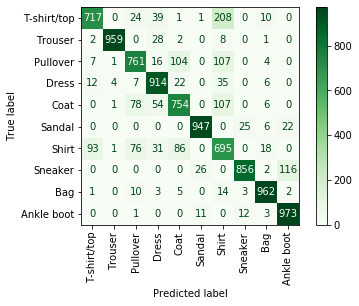

In [53]:
#Confusion Matrix
cm = confusion_matrix(Y_test_label, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_dataset.classes)
disp.plot(cmap='Greens', xticks_rotation='vertical', values_format='d')

In [54]:
print(classification_report(Y_test_label,predictions))

              precision    recall  f1-score   support

           0       0.86      0.72      0.78      1000
           1       0.99      0.96      0.98      1000
           2       0.80      0.76      0.78      1000
           3       0.84      0.91      0.88      1000
           4       0.77      0.75      0.76      1000
           5       0.96      0.95      0.95      1000
           6       0.59      0.69      0.64      1000
           7       0.96      0.86      0.90      1000
           8       0.94      0.96      0.95      1000
           9       0.87      0.97      0.92      1000

    accuracy                           0.85     10000
   macro avg       0.86      0.85      0.85     10000
weighted avg       0.86      0.85      0.85     10000



### B2.4c

In [55]:
#CNN with five Conv layers and two FC layers.
class CNNet3(nn.Module):
    def __init__(self):
        super(CNNet3, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 10, 5)
        self.conv3 = nn.Conv2d(10, 14, 5)
        self.conv4 = nn.Conv2d(14, 18, 5)
        self.conv5 = nn.Conv2d(18, 24, 5)
        self.fc1 = nn.Linear(24 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.pool(F.relu(self.conv5(x)))
        x = x.view(-1, 24 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

CNN_Classifier = CNNet3()

In [56]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(CNN_Classifier.parameters(), lr=0.001, momentum=0.9)
max_epochs=4

In [57]:
t0 = time.time()
for epoch in range(max_epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = CNN_Classifier(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 1500 == 1499:    # print every 1500 mini-batches
            print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 1500))
            running_loss = 0.0

t1 = time.time()
print('Finished Training!')

[1,  1500] loss: 2.302
[1,  3000] loss: 1.241
[1,  4500] loss: 0.746
[1,  6000] loss: 0.650
[1,  7500] loss: 0.600
[2,  1500] loss: 0.565
[2,  3000] loss: 0.558
[2,  4500] loss: 0.512
[2,  6000] loss: 0.507
[2,  7500] loss: 0.480
[3,  1500] loss: 0.469
[3,  3000] loss: 0.464
[3,  4500] loss: 0.451
[3,  6000] loss: 0.446
[3,  7500] loss: 0.429
[4,  1500] loss: 0.429
[4,  3000] loss: 0.398
[4,  4500] loss: 0.417
[4,  6000] loss: 0.408
[4,  7500] loss: 0.408
Finished Training!


In [58]:
#M1 - Training Accuracy (Accuracy for train data)
correct = 0
total = 0
for images, labels in trainloader:
    outputs = CNN_Classifier(images)
    _, predicted = torch.max(outputs.data, 1)
    total+= labels.size(0)
    correct+= (predicted == labels).sum().item()
    
tr_accuracy_cnn3 = 100 * correct/total
print('Accuracy of the network on the 60000 train images: ', tr_accuracy_cnn3)

Accuracy of the network on the 60000 train images:  86.44833333333334


In [59]:
#M2 - Testing Accuracy (Accuracy for test data)
correct = 0
total = 0
Y_test_label = []
predictions = []
for images, labels in testloader:
    outputs = CNN_Classifier(images)
    _, predicted = torch.max(outputs.data, 1)
    total+= labels.size(0)
    correct+= (predicted == labels).sum().item()
    Y_test_label.extend(labels.tolist())
    predictions.extend(predicted.tolist())
    
te_accuracy_cnn3 = 100 * correct/total
print('Accuracy of the network on the 10000 test images: ', te_accuracy_cnn3)

Accuracy of the network on the 10000 test images:  85.34


In [60]:
#M3 - Training Time in secs
tt_cnn3 = round(t1-t0, 3)
tt_cnn3

264.045

In [61]:
#M4 - Learnable Parameters
conV1 = (5*5*1 + 1)*6    #5x5 kernel, 6 output feature maps, 1 input channel
conV2 = (5*5*6 + 1)*10    #5x5 kernel, 10 output feature maps, 6 input channel
conV3 = (5*5*10 + 1)*14    #5x5 kernel, 14 output feature maps, 10 input channel
conV4 = (5*5*14 + 1)*18    #5x5 kernel, 18 output feature maps, 14 input channel
conV5 = (5*5*18 + 1)*24    #5x5 kernel, 24 output feature maps, 18 input channel
fc1 = (24*4*4 + 1)*120    #16x4x4 input, 120 output units
fc2 = (120 + 1)*10        #120 input, 10 output
total_cnn3_params = conV1 + conV2 + conV3 + conV4 + conV5 + fc1 + fc2
print("Learnable Parameters of the model:", total_cnn3_params)

Learnable Parameters of the model: 69732


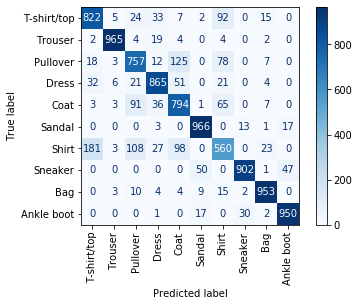

In [62]:
#Confusion Matrix
cm = confusion_matrix(Y_test_label, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_dataset.classes)
disp.plot(cmap='Blues', xticks_rotation='vertical', values_format='d')

In [63]:
print(classification_report(Y_test_label,predictions))

              precision    recall  f1-score   support

           0       0.78      0.82      0.80      1000
           1       0.98      0.96      0.97      1000
           2       0.75      0.76      0.75      1000
           3       0.86      0.86      0.86      1000
           4       0.73      0.79      0.76      1000
           5       0.92      0.97      0.94      1000
           6       0.67      0.56      0.61      1000
           7       0.95      0.90      0.93      1000
           8       0.94      0.95      0.95      1000
           9       0.94      0.95      0.94      1000

    accuracy                           0.85     10000
   macro avg       0.85      0.85      0.85     10000
weighted avg       0.85      0.85      0.85     10000



## B2.5 Performance Comparison

### B2.5a

Below are the bar graphs showing the performance metrics of each model from B2.3 and B2.4.

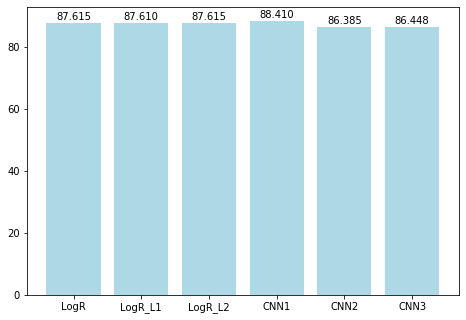

In [64]:
#bar graph for M1
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
model_name = ['LogR', 'LogR_L1', 'LogR_L2', 'CNN1', 'CNN2', 'CNN3']
tr_accuracy = [tr_score_lr*100,tr_score_lr_l1*100,tr_score_lr_l2*100,tr_accuracy_cnn1,tr_accuracy_cnn2,tr_accuracy_cnn3]
ax.bar(model_name,tr_accuracy,color="lightblue")
for index, value in enumerate(tr_accuracy):
    ax.text(index, value + 1, str("{0:.3f}".format(value)), ha="center")    

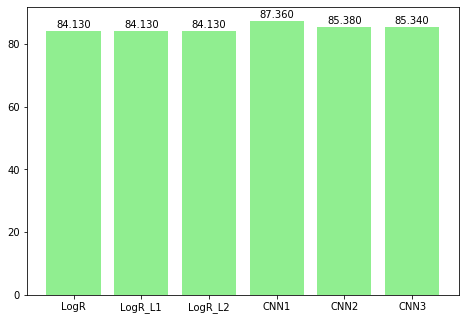

In [65]:
#bar graph for M2
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
model_name = ['LogR', 'LogR_L1', 'LogR_L2', 'CNN1', 'CNN2', 'CNN3']
te_accuracy = [te_score_lr*100,te_score_lr_l1*100,te_score_lr_l2*100,te_accuracy_cnn1,te_accuracy_cnn2,te_accuracy_cnn3]
ax.bar(model_name,te_accuracy,color="lightgreen")
for index, value in enumerate(te_accuracy):
    ax.text(index, value + 1, str("{0:.3f}".format(value)), ha="center")    

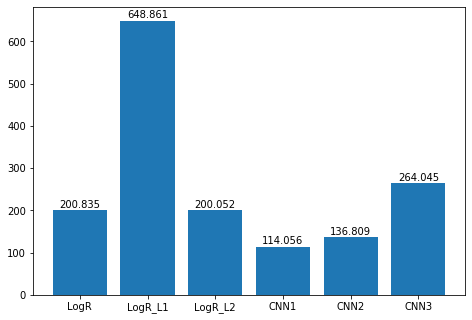

In [66]:
#bar graph for M3
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
model_name = ['LogR', 'LogR_L1', 'LogR_L2', 'CNN1', 'CNN2', 'CNN3']
train_time = [tt_lr,tt_lr_l1,tt_lr_l2,tt_cnn1,tt_cnn2,tt_cnn3]
ax.bar(model_name,train_time)
for index, value in enumerate(train_time):
    ax.text(index, value + 6, str("{0:.3f}".format(value)), ha="center")    

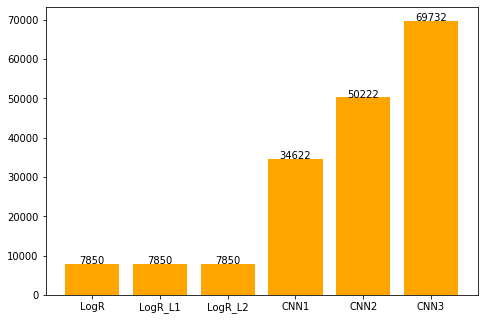

In [67]:
#bar graph for M4
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
model_name = ['LogR', 'LogR_L1', 'LogR_L2', 'CNN1', 'CNN2', 'CNN3']
lr_params = [total_lor_params,total_lor_l1_params,total_lor_l2_params,total_cnn1_params,total_cnn2_params,total_cnn3_params]
ax.bar(model_name,lr_params, color="orange")
for index, value in enumerate(lr_params):
    ax.text(index, value + 1, str(value), ha="center")    

### B2.5b

#### Observations:
1. The CNN models have performed slightly better on the testing data, and also the F1-score for the products like Pullover, Coat and Shirt are better when compared to Logistic model.
2. The CNN models are comparatively faster given the total learnable parameters are high and overall the logistic model with l1 regularization has taken the highest training time.
3. All the variants of the logistic model though applied regularization, yielded the same traing and testing accuracies this might be due to the fact that they didn't converge.    

# Section 3: Unsupervised learning on Fashion-MNIST

## B3.1 PCA and k-means

### B3.1a

For this part of the assessment, I have chosen Trouser and Pullover classes of the Fashion-MNIST data.

In [68]:
#Subset of the dataset with only two classes
train_subset = train_dataset
idx = (train_subset.targets==1) | (train_subset.targets==2)
train_subset.targets = train_subset.targets[idx]
train_subset.data = train_subset.data[idx]

train_subset = list(train_subset)

In [69]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

choosing n_components as 24 instead of percenatge variance to be explained (such that it will select the appropriate components) so that the model would be directly used for the further steps.

In [70]:
X = np.array(train_subset[:][0][0].numpy()).reshape(1, 28*28)
Y = [train_subset[:][0][1]]
for i in range(1, len(train_subset[:])):
    X = np.append(X,np.array(train_subset[:][i][0].numpy()).reshape(1, 28*28),axis = 0)
    Y = np.append(Y,train_subset[:][i][1])
scaler = StandardScaler()
X_norm = scaler.fit_transform(X)

pca = PCA(n_components=24, random_state=1746174)
pca.fit(X_norm)
cov_matrix = np.dot(X_norm.T, X_norm) / len(X_norm)

for eigenvector in pca.components_[:]:
    print(np.dot(eigenvector.T, np.dot(cov_matrix, eigenvector)))

210.86331
113.95599
62.78781
29.87734
23.630703
19.945297
17.059772
13.909358
12.6476345
11.681675
10.093945
8.959505
8.415084
8.0481
7.550539
7.455929
6.368985
6.056802
5.7174263
5.523382
5.0266113
4.5960264
4.333377
4.2865915


In [71]:
sum(pca.explained_variance_ratio_)

0.7775098718702793

In [72]:
pca.explained_variance_

array([210.88084  , 113.965485 ,  62.793083 ,  29.879837 ,  23.632696 ,
        19.946987 ,  17.061205 ,  13.910532 ,  12.648686 ,  11.68265  ,
        10.094783 ,   8.960254 ,   8.415783 ,   8.048773 ,   7.551167 ,
         7.4565563,   6.3695126,   6.0572853,   5.717893 ,   5.523828 ,
         5.0269628,   4.595548 ,   4.3332787,   4.2865324], dtype=float32)

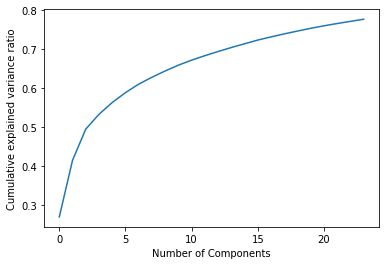

In [73]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative explained variance ratio');

In [74]:
eigenimages = pca.components_.reshape((24, 28, 28))

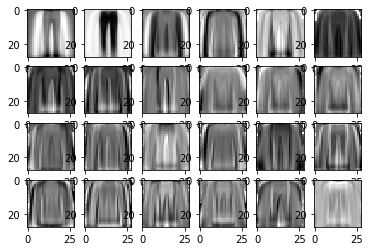

In [75]:
# show images of the top 24 eigen vectors in the descending order from left to right.
for j in range(0,24):
    plt.subplot(4, 6, j+1)
    plt.imshow(eigenimages[j], cmap=plt.get_cmap('gray'))
    
plt.show()


We can see from the plots that these eigen vectors captured the important information of both the classes.

### B3.1b

In [76]:
X_norm_r = pca.transform(X_norm)

Below is the function that plot the original and reconstructed images given the sample count of images and the class.

In [77]:
import seaborn as sns

def plot_reconstructions(n_samples, class_label):
    fig, axarr = plt.subplots(n_samples, 2, figsize=(12, n_samples*3))
    class_ind = np.where(Y == class_label)
    for i in range(0,n_samples):
        inv = pca.inverse_transform(X_norm_r[class_ind[0][i], :])
        inv = scaler.inverse_transform(inv) #Unnormalize
        sns.heatmap(X[class_ind[0][i], :].reshape(28, 28), cmap='gray_r', ax=axarr[i,0])
        sns.heatmap(inv.reshape(28, 28), cmap='gray_r', ax=axarr[i,1])
        axarr[i,0].axis('off')
        axarr[i,1].axis('off')
        axarr[i,0].set_title("Original Image", fontsize=12)
        axarr[i,1].set_title("Reconstructed", fontsize=12)
        axarr[i,0].set_aspect('equal')
        axarr[i,1].set_aspect('equal')
    plt.show()

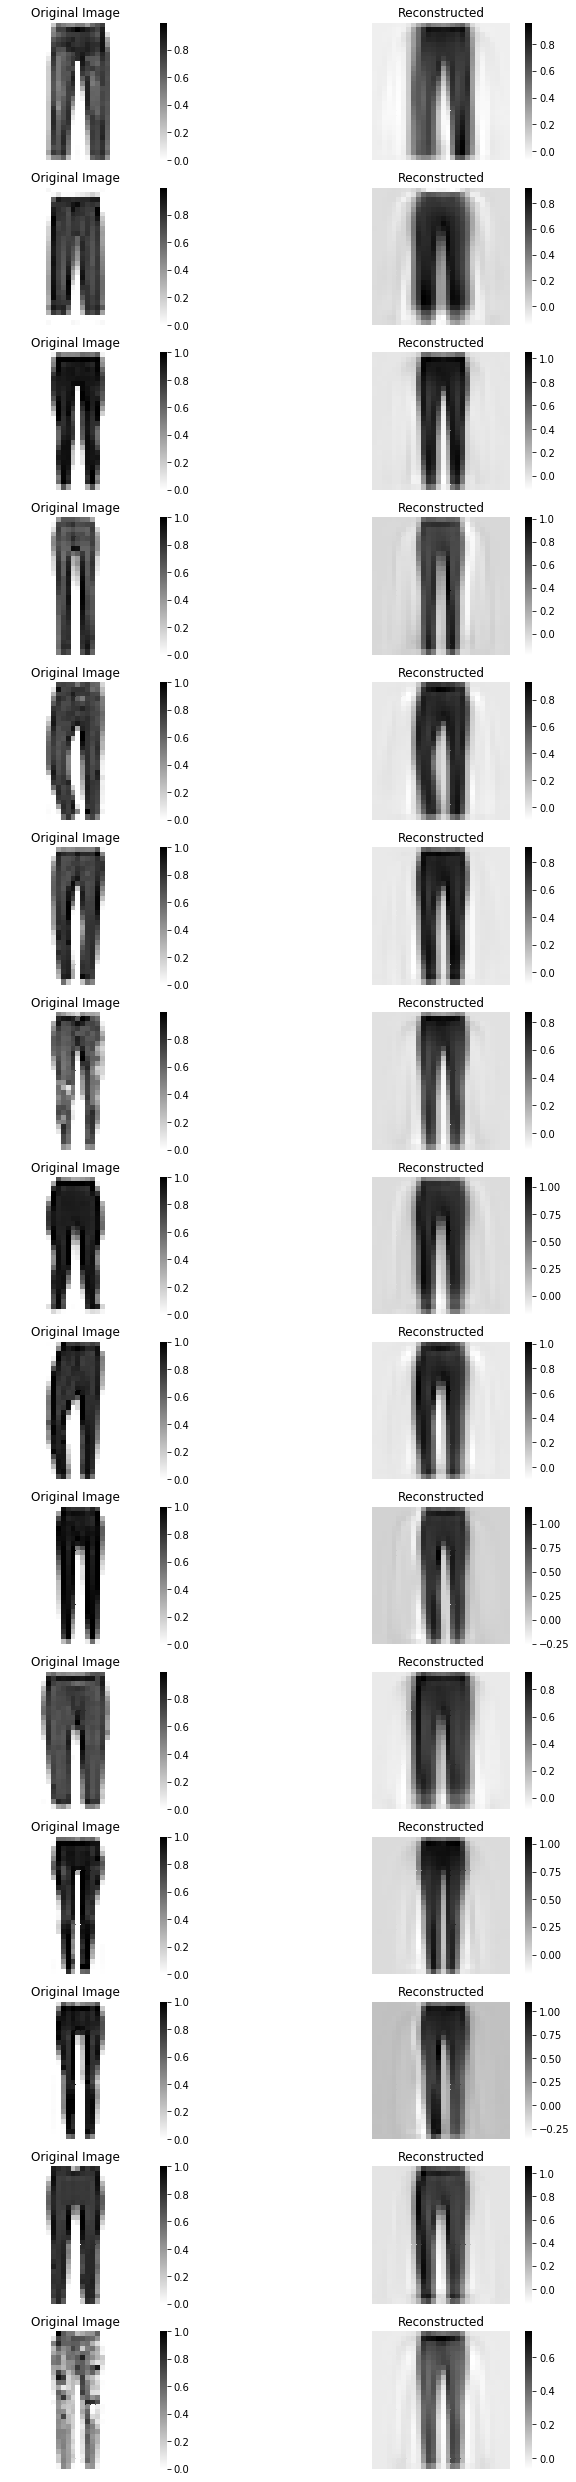

In [78]:
#pairs of reconstructed and original images for class "Trouser"
plot_reconstructions(15, 1)

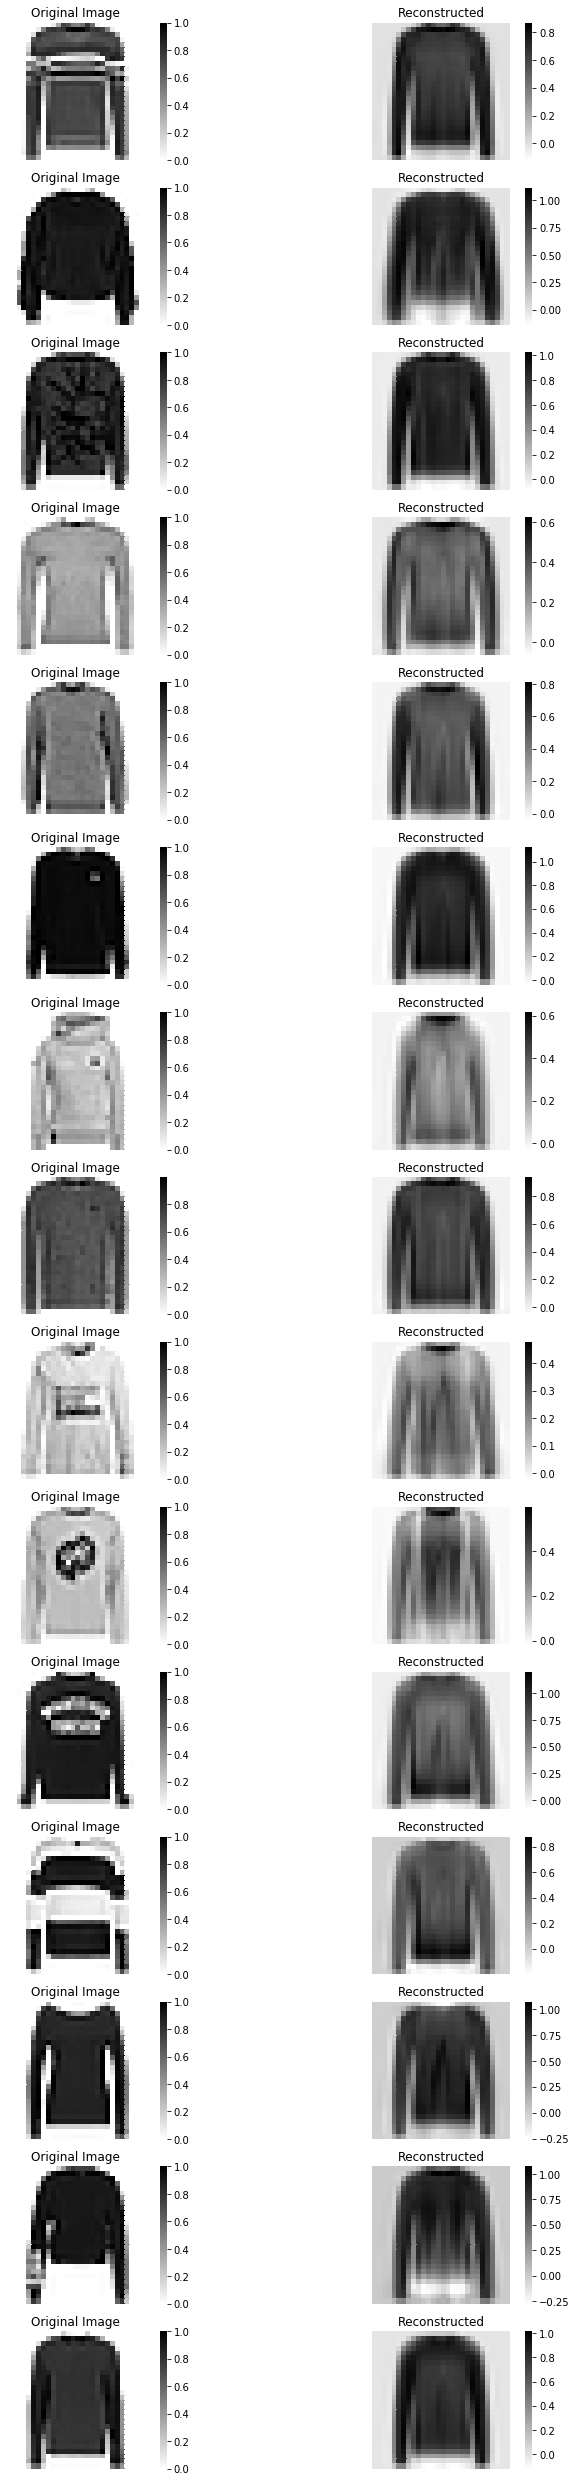

In [79]:
#pairs of reconstructed and original images for class "Pullover"
plot_reconstructions(15, 2)

In [80]:
#to find mse for these 30 data points
def getMSE():
    squared_error = []
    for lbl in range(1,3):
        class_ind = np.where(Y == lbl)
        for i in range(0,15):
            inv = pca.inverse_transform(X_norm_r[class_ind[0][i], :])
            inv = scaler.inverse_transform(inv)
            squared_error.append(np.square(np.subtract(X[class_ind[0][i], :].reshape(28, 28),inv.reshape(28, 28))))
            
    mse = np.array(squared_error).mean()
    return mse

In [81]:
print("MSE for the 30 images:", getMSE())

MSE for the 30 images: 0.014817932


### B3.1c

In [82]:
principalDf = pd.DataFrame(data = X_norm_r)

In [83]:
principalDf.head()

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
0,16.075523,1.708074,-4.215400,-5.187794,3.567535,2.581302,-2.591541,5.079515,1.018074,-0.879103,...,-1.341708,1.454593,-0.356362,1.754583,0.272395,-0.580027,-0.877619,1.138862,-2.307020,-1.440485
1,35.008224,-3.348914,14.782865,-10.044715,5.429846,-1.628123,-4.203313,-10.418776,-3.850507,-1.517437,...,1.366931,-0.379589,-4.932378,0.386521,0.819311,5.205146,2.622908,-0.072757,3.404176,0.984219
2,-7.186563,-4.938490,1.005385,1.683461,-9.927174,3.945251,-3.065985,-1.804282,3.547243,1.114113,...,-0.237722,1.072566,-3.502079,0.266879,1.079937,-0.502754,1.542125,1.064752,-3.442910,1.406384
3,-7.914638,-6.752097,0.439017,1.980812,-2.048085,0.644127,-0.855328,2.106413,-3.904580,-2.709737,...,7.973652,-1.132949,-0.160723,-0.911615,1.656226,-1.407798,0.803943,2.291478,-1.284088,3.266555
4,27.353043,-6.908291,-2.719556,-6.099669,4.500875,2.535785,-2.600034,3.268742,-0.040559,-0.193015,...,-2.538168,-3.521579,-0.988469,0.249696,2.908928,-0.814474,-2.122236,2.573620,-1.951013,-2.231317


In [84]:
labels = Y
targets = labels.astype(str)
targets[targets == '2'] = 'Pullover'
targets[targets == '1'] = 'Trouser'

In [85]:
finalDf = pd.concat([principalDf, pd.DataFrame({'target': targets.tolist()})], axis = 1)

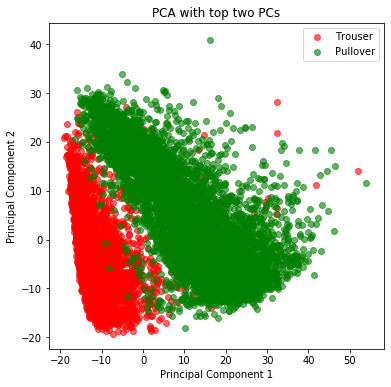

In [86]:
#Plot the PCA representations of all data points in a 2D plane using the top two PCs
fig = plt.figure(figsize = (6,6))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_title('PCA with top two PCs')
targets = ['Trouser', 'Pullover']
colors = ['r', 'g']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['target'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 0]
               , finalDf.loc[indicesToKeep, 1]
               , c = color
               , alpha=0.6)
ax.legend(targets)

### B3.1d

In [87]:
#k-means to cluster all data points as represented by the top two PCs
df_pc = principalDf.iloc[:,[0,1]].values

In [88]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=2, init="k-means++", random_state=1746174)
kmeans_cluster = kmeans.fit_predict(df_pc)

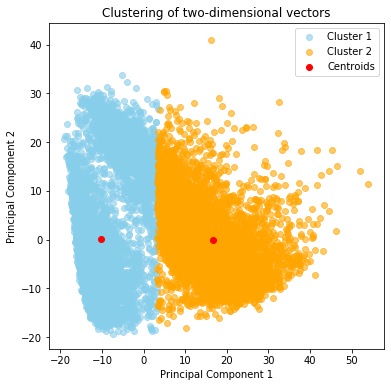

In [89]:
fig = plt.figure(figsize = (6,6))
fig.add_subplot(1,1,1)
plt.scatter(df_pc[kmeans_cluster == 0, 0], df_pc[kmeans_cluster == 0, 1], c = "skyblue", label = "Cluster 1", alpha=0.6)
plt.scatter(df_pc[kmeans_cluster == 1, 0], df_pc[kmeans_cluster == 1, 1], c = "orange", label = "Cluster 2", alpha=0.6)
plt.scatter(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1], c = "red", label = "Centroids")
plt.title("Clustering of two-dimensional vectors")
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()

In [90]:
kmeans.score(df_pc)

-1848301.4

## B3.2 AutoEncoder

### B3.2a

In [91]:
torch.manual_seed(1746174)

The kernel sizes, stride, padding and other parameters are chosen accordingly using the convolution and transposeconvolution width & height output formulae as mentioned in the pytorch Conv2d and ConvTranspose2d API to get the desired output dimensions.

In [92]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            # 1 input image channel, 16 output channel, 3x3 square convolution
            nn.Conv2d(1, 16, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 256, 2)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, 2),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 3),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()  #to range [0, 1]
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [93]:
Model_AE = Autoencoder()
#print(Model_AE)

In [94]:
#Training (optimisation) parameters
batch_size=100
learning_rate=1e-3
max_epochs = 20
train_mse_loss = []

#Choose mean square error loss
criterion = nn.MSELoss() 
#Choose the Adam optimiser
optimizer = torch.optim.Adam(Model_AE.parameters(), lr=learning_rate, weight_decay=1e-5)
train_loader = torch.utils.data.DataLoader(train_subset, batch_size=batch_size, shuffle=True)
#Storage
outputs = []

#Start training
for epoch in range(max_epochs):
    running_loss = 0.0
    for data in train_loader:
        img, label = data
        optimizer.zero_grad()
        recon = Model_AE(img)
        loss = criterion(recon, img)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
    loss = running_loss / len(train_loader)    
    train_mse_loss.append(loss)
    #if (epoch % 1) == 0:
    print('Epoch:{}, Loss:{:.4f}'.format(epoch+1, float(loss)))
    outputs.append((epoch, img, recon),)

Epoch:1, Loss:0.0752
Epoch:2, Loss:0.0314
Epoch:3, Loss:0.0242
Epoch:4, Loss:0.0213
Epoch:5, Loss:0.0179
Epoch:6, Loss:0.0157
Epoch:7, Loss:0.0139
Epoch:8, Loss:0.0127
Epoch:9, Loss:0.0119
Epoch:10, Loss:0.0113
Epoch:11, Loss:0.0107
Epoch:12, Loss:0.0102
Epoch:13, Loss:0.0099
Epoch:14, Loss:0.0097
Epoch:15, Loss:0.0094
Epoch:16, Loss:0.0091
Epoch:17, Loss:0.0088
Epoch:18, Loss:0.0086
Epoch:19, Loss:0.0083
Epoch:20, Loss:0.0082


Since we are using the MSELoss, the loss would be the mse at each epoch so we plot the loss against epoch.

Text(0, 0.5, 'Loss')

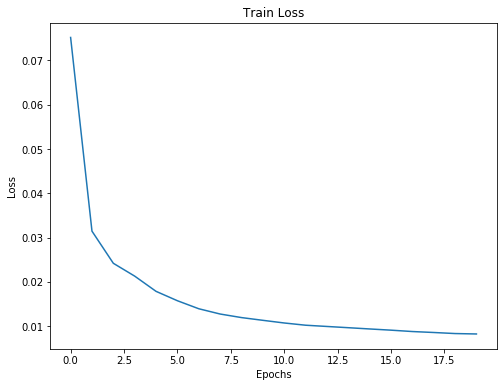

In [95]:
plt.figure(figsize = (8,6))
plt.plot(train_mse_loss)
plt.title('Train Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

### B3.2b

In [96]:
#encoder that gives the code (bottleneck) with a dimension of 2. 

In [97]:
class Autoencoder_2D_BN(nn.Module):
    def __init__(self):
        super(Autoencoder_2D_BN, self).__init__()
        self.encoder = nn.Sequential(
            # 1 input image channel, 16 output channel, 3x3 square convolution
            nn.Conv2d(1, 16, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 2, 2)  #changed here: output of 1x1, 2 channels
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(2, 128, 2), #changed here:to get 128 output channels with 2x2
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 3),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()  #to range [0, 1]
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [98]:
Model_En = Autoencoder_2D_BN()

In [99]:
max_epochs = 20

#Training (optimisation) parameters
criterion = nn.MSELoss() 
#Choose the Adam optimiser
optimizer = torch.optim.Adam(Model_En.parameters(), lr=learning_rate, weight_decay=1e-5)
#Storage
outputs = []

#Start training
for epoch in range(max_epochs):
    running_loss = 0.0
    for data in train_loader:
        img, label = data
        optimizer.zero_grad()
        recon = Model_En(img)
        loss = criterion(recon, img)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
    loss = running_loss / len(train_loader)    
    #if (epoch % 1) == 0:
    print('Epoch:{}, Loss:{:.4f}'.format(epoch+1, float(loss)))
    outputs.append((epoch, img, recon),)

Epoch:1, Loss:0.0979
Epoch:2, Loss:0.0444
Epoch:3, Loss:0.0331
Epoch:4, Loss:0.0268
Epoch:5, Loss:0.0255
Epoch:6, Loss:0.0249
Epoch:7, Loss:0.0244
Epoch:8, Loss:0.0240
Epoch:9, Loss:0.0238
Epoch:10, Loss:0.0235
Epoch:11, Loss:0.0232
Epoch:12, Loss:0.0229
Epoch:13, Loss:0.0227
Epoch:14, Loss:0.0225
Epoch:15, Loss:0.0224
Epoch:16, Loss:0.0222
Epoch:17, Loss:0.0221
Epoch:18, Loss:0.0220
Epoch:19, Loss:0.0220
Epoch:20, Loss:0.0220


In [100]:
#using encoder to get the output at bottleneck
df_output = []
df_label = []
for data in train_loader:
    img, label = data
    recon = Model_En.encoder(img)
    df_output.extend((recon.detach().numpy()).reshape(100,2))
    df_label.extend(label.detach().numpy())

In [101]:
code_df = pd.DataFrame(np.vstack(df_output))

In [102]:
labels = np.array(df_label)
targets = labels.astype(str)
targets[targets == '2'] = 'Pullover'
targets[targets == '1'] = 'Trouser'

In [103]:
final_code_Df = pd.concat([code_df, pd.DataFrame({'target': targets.tolist()})], axis = 1)

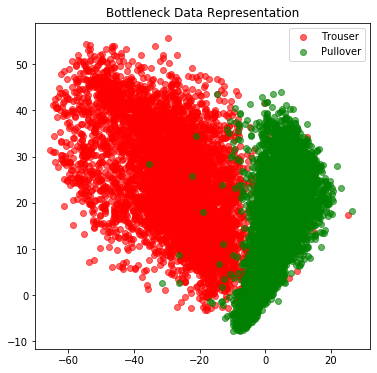

In [104]:
#Plot the 2-dimensional representations in terms of this autoencoder code for all data points in a 2D plane
fig = plt.figure(figsize = (6,6))
ax = fig.add_subplot(1,1,1) 
#ax.set_xlabel('')
#ax.set_ylabel('')
ax.set_title('Bottleneck Data Representation')
targets = ['Trouser', 'Pullover']
colors = ['r', 'g']
for target, color in zip(targets,colors):
    indicesToKeep = final_code_Df['target'] == target
    ax.scatter(final_code_Df.loc[indicesToKeep, 0]
               , final_code_Df.loc[indicesToKeep, 1]
               , c = color
               , alpha=0.6)
ax.legend(targets)

In [105]:
#cluster them with similar colour/marker visualisation as earlier.
df_bn = final_code_Df.iloc[:,[0,1]].values

In [106]:
kmeans = KMeans(n_clusters=2, init="k-means++", random_state=1746174)
cluster = kmeans.fit_predict(df_bn)

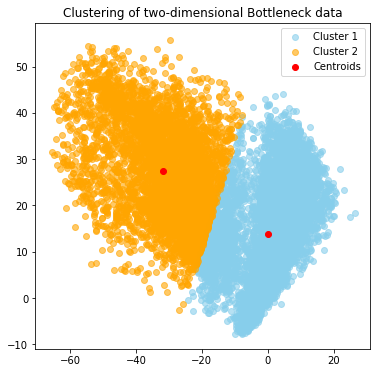

In [107]:
fig = plt.figure(figsize = (6,6))
fig.add_subplot(1,1,1)
plt.scatter(df_bn[cluster == 0, 0], df_bn[cluster == 0, 1], c = "skyblue", label = "Cluster 1", alpha=0.6)
plt.scatter(df_bn[cluster == 1, 0], df_bn[cluster == 1, 1], c = "orange", label = "Cluster 2", alpha=0.6)
plt.scatter(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1], c = "red", label = "Centroids")
plt.title("Clustering of two-dimensional Bottleneck data")
#plt.xlabel('')
#plt.ylabel('')
plt.legend()
plt.show()

In [108]:
kmeans.score(df_bn)

-2381216.0

## B3.3 Observation

1. From the above PCA implementation almost 77.75% variance explained by the top 24 components alone. We can see that even with the reduced dimensionality we still be able to predict the classes with the most of the important feature information and the MSE value for the selected 30 images also came out to be very low.  
2. K-Means score (negative of K-means objective or within-cluster sum of squares) is low for the data represented by the top two PCs from PCA when compared to the data at bottlneck from the autoencoder, but in both the cases it didn't form pure clusters.

# Section 4: References

**Reference List:**

1. Lab 6 - Logistic Regression & PyTorch for Deep Learning
2. Lab 7 - Convolutional Neural Networks for Image Classification
3. Lab 8 - Unsupervised Learning from Unlabelled Data


4. API Reference: 
   
   https://scikit-learn.org/stable/modules/classes.html#
   
   https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html
   
   https://pytorch.org/docs/master/generated/torch.nn.Conv2d.html?highlight=conv#torch.nn.Conv2d
   
   https://pytorch.org/docs/master/generated/torch.nn.ConvTranspose2d.html?highlight=transpose%20layer
   
   https://matplotlib.org/3.1.1/index.html
   

5. Logistic:
   
   https://web.stanford.edu/~jurafsky/slp3/5.pdf
   
   https://www.kaggle.com/joparga3/2-tuning-parameters-for-logistic-regression
   
   https://medium.com/technology-nineleaps/logistic-regression-gradient-descent-optimization-part-1-ed320325a67e
   
   https://towardsdatascience.com/logistic-regression-on-mnist-with-pytorch-b048327f8d19


6. CNN:
   
   https://medium.com/@iamvarman/how-to-calculate-the-number-of-parameters-in-the-cnn-5bd55364d7ca
   
   https://pytorch.org/docs/stable/torchvision/datasets.html#fashion-mnist
   
   https://towardsdatascience.com/understanding-and-calculating-the-number-of-parameters-in-convolution-neural-networks-cnns-fc88790d530d
   
   https://www.analyticsvidhya.com/blog/2019/10/building-image-classification-models-cnn-pytorch/


7. PCA:
   
   https://jakevdp.github.io/PythonDataScienceHandbook/05.09-principal-component-analysis.html
   
   https://towardsdatascience.com/pca-using-python-scikit-learn-e653f8989e60
   
   https://github.com/mGalarnyk/Python_Tutorials/blob/master/Sklearn/PCA/PCA_Data_Visualization_Iris_Dataset_Blog.ipynb


8. k-Means:
   
   Udemy course: Machine Learning A-Z™: Hands-On Python & R In Data Science - k-Means clustering
   
   https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html?highlight=kmeans#sklearn.cluster.KMeans
   
   https://medium.com/pursuitnotes/k-means-clustering-model-in-6-steps-with-python-35b532cfa8ad


9. Autoencoder:
   
   https://jannik-zuern.medium.com/but-what-is-an-autoencoder-26ec3386a2af
   
   https://towardsdatascience.com/autoencoders-in-keras-c1f57b9a2fd7
   
   https://analyticsindiamag.com/hands-on-guide-to-implement-deep-autoencoder-in-pytorch-for-image-reconstruction/